# Compliance Risk Modeling

This notebook explores transaction risk detection under compliance and regulatory constraints, focusing on precision–recall tradeoffs rather than raw accuracy.

# Compliance Risk Modeling: Transaction Classification

This notebook demonstrates how machine learning models can be used to flag potentially risky transactions under compliance and regulatory constraints.

The focus is on:
  - Imbalanced data
  - Precision–recall tradeoffs
  - Explainability and governance

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve


In [4]:
df = pd.read_csv("creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df['Class'].value_counts(normalize=True)


,proportion
Class,
0,0.998273
1,0.001727


### Class Imbalance

Fraudulent transactions are extremely rare in real-world financial systems.
This imbalance makes accuracy a misleading metric for compliance decision-making.


In [6]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443



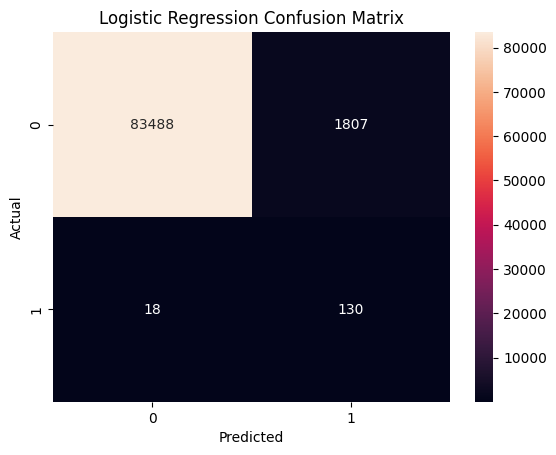

In [8]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [9]:
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.97      0.70      0.82       148

    accuracy                           1.00     85443
   macro avg       0.99      0.85      0.91     85443
weighted avg       1.00      1.00      1.00     85443



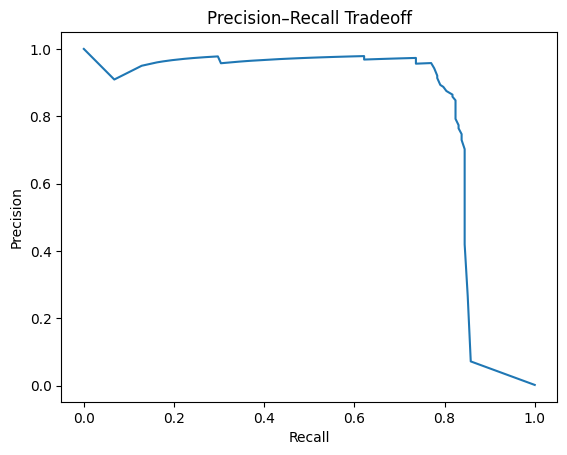

In [10]:
y_scores = rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Tradeoff")
plt.show()


### Compliance Tradeoff

Adjusting the decision threshold changes the balance between:
- Catching risky transactions (recall)
- Avoiding false positives that harm legitimate users (precision)

In compliance systems, this tradeoff must be policy-driven, not purely technical.


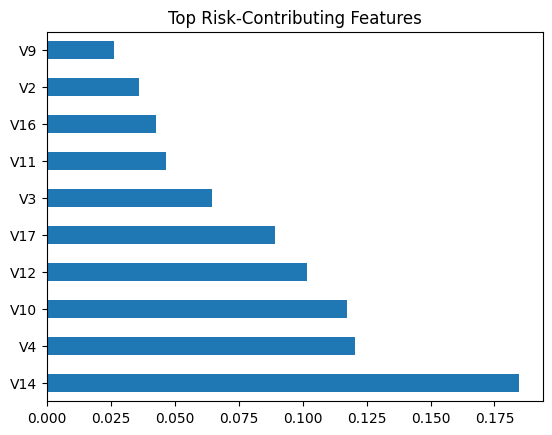

In [11]:
importances = rf.feature_importances_
features = X.columns

fi = pd.Series(importances, index=features).sort_values(ascending=False)[:10]
fi.plot(kind='barh')
plt.title("Top Risk-Contributing Features")
plt.show()


### Explainability

Tree-based models allow inspection of feature importance, supporting transparent explanations for why transactions are flagged.
